In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor
from PIL import Image
from tqdm import tqdm
import os,json
from utils_evaluate_model import *
from models import * 
import torchvision.utils as vutils
import os, time

In [ ]:
# --- (1) nom du modèle à charger -----------------------------------------------------
image_name = "oiseau"
model_name = "basic"

im_name_to_path = {
    "oiseau" : "images/birds.png",
    "zebre" : "images/zebra.png"
}

In [3]:

model_dir  = os.path.join("models",image_name ,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")  

if not os.path.exists(weights_fp):
    raise FileNotFoundError(f"Impossible de trouver le fichier : {weights_fp}")

# --- (2) on lit la liste de state_dict ----------------------------------------------
state_list = torch.load(weights_fp, map_location="cpu")
print(f"{len(state_list)} générateurs trouvés dans le checkpoint")

# (facultatif) on affiche le petit fichier description
if os.path.isfile(descr_fp):
    print("─── Description.txt ───")
    with open(descr_fp, encoding="utf-8") as f:
        print(f.read().strip())
    print("────────────────────────\n")

# --- (2bis) on charge la liste sigma_n ----------------------------------------------
if os.path.isfile(sigma_fp):
    with open(sigma_fp, "r", encoding="utf-8") as f:
        loaded_sigma_n = json.load(f)
    print(f"sigma_n chargé ({len(loaded_sigma_n)} éléments) → 'loaded_sigma_n'")
else:
    raise FileNotFoundError(f"Impossible de trouver le fichier sigma_n : {sigma_fp}")

# --- (2ter) on charge z_star -------------------------------------------------------
if os.path.isfile(zstar_fp):
    loaded_z_star = torch.load(zstar_fp, map_location="cpu")
    print(f"z_star chargé de taille {tuple(loaded_z_star.shape)} → 'loaded_z_star'")
else:
    raise FileNotFoundError(f"Impossible de trouver le fichier z_star : {zstar_fp}")

# --- (4) on construit la liste des générateurs chargés ------------------------------
device = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
loaded_generators = [build_generator_from_state(sd, device=device) for sd in state_list]

print(f"{len(loaded_generators)} générateurs instanciés → 'loaded_generators'")
print("device :", device)


8 générateurs trouvés dans le checkpoint
─── Description.txt ───
date: 2025-05-30T16:14:07
N: 8
lambda_gp: 10
r: 1.333
lr: 0.0005
betas: (0.5, 0.999)
n_Discriminator: 5
n_Generator: 2
iter_per_scale: 2000
alpha_rec: 10
beta_sigma: 0.1
comment: Sin Gan avec poids classique comme dans le papier sauf le padding
────────────────────────

sigma_n chargé (8 éléments) → 'loaded_sigma_n'
z_star chargé de taille (1, 3, 21, 32) → 'loaded_z_star'
8 générateurs instanciés → 'loaded_generators'
device : cuda


In [4]:
loaded_params = {}
with open(descr_fp, encoding="utf-8") as f:
    for line in f:
        if ": " not in line:
            continue
        key, val = line.strip().split(": ", 1)
        loaded_params[key] = val

# Conversion au bon type
loaded_N = int(loaded_params["N"])
loaded_r = float(loaded_params["r"])  




In [5]:
loaded_params

{'date': '2025-05-30T16:14:07',
 'N': '8',
 'lambda_gp': '10',
 'r': '1.333',
 'lr': '0.0005',
 'betas': '(0.5, 0.999)',
 'n_Discriminator': '5',
 'n_Generator': '2',
 'iter_per_scale': '2000',
 'alpha_rec': '10',
 'beta_sigma': '0.1',
 'comment': 'Sin Gan avec poids classique comme dans le papier sauf le padding'}

In [6]:
path = im_name_to_path[image_name]
im = Image.open(path).convert("RGB")
im_tensor_cpu = to_tensor(im).to(device="cpu")
im_tensor_mps =to_tensor(im).to(device) 
print(f"inital tensor size : {im_tensor_cpu.shape}")

max_dim = 250
_, H, W = im_tensor_mps.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor_mps.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0) *2 -1

print(f"rescaled tensor size : {im_resized.shape}")

# Compute the different scales
scales = [im_resized.unsqueeze(0)]  

for i in range(0, loaded_N):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / loaded_r), 1)
    new_w = max(int(w / loaded_r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)


inital tensor size : torch.Size([3, 164, 244])
rescaled tensor size : torch.Size([3, 168, 249])


saved → outputs/oiseau/gen_20250615_165603_1.png
saved → outputs/oiseau/gen_20250615_165603_2.png
saved → outputs/oiseau/gen_20250615_165603_3.png
saved → outputs/oiseau/gen_20250615_165603_4.png
saved → outputs/oiseau/gen_20250615_165603_5.png
saved → outputs/oiseau/gen_20250615_165604_6.png
saved → outputs/oiseau/gen_20250615_165604_7.png
saved → outputs/oiseau/gen_20250615_165604_8.png


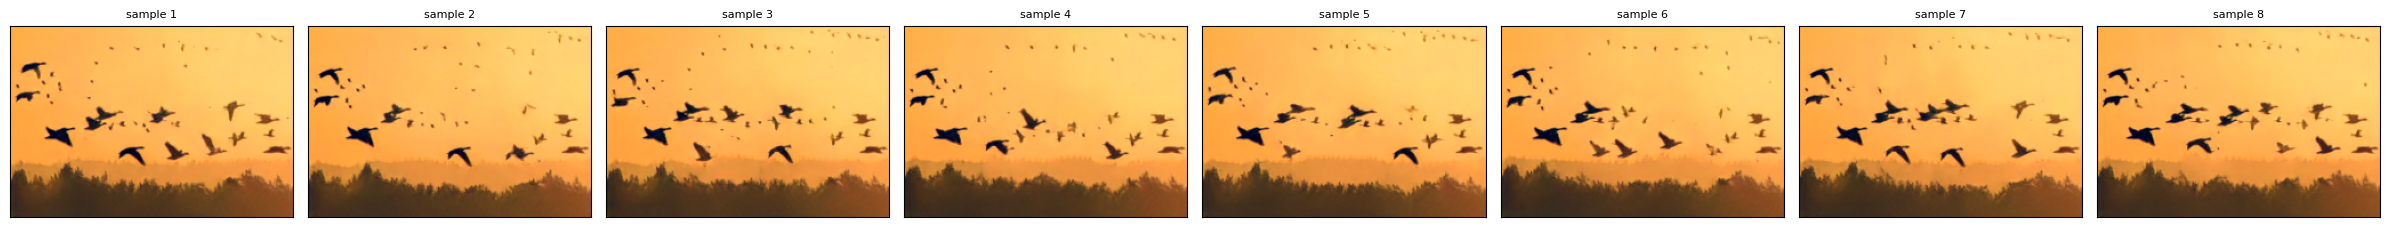

In [7]:
# dossier de sortie
out_dir = "outputs/" + image_name
os.makedirs(out_dir, exist_ok=True)

# Nombre de générations
K = 8
final_imgs = []
for k in range(K):
    imgs = generate_multiscale(imgs_ref=scales, Generators=loaded_generators,sigma_n=loaded_sigma_n,N=loaded_N,device=device,start_scale=loaded_N-1)
    final_imgs.append(imgs[0].cpu().squeeze())      # 0 : finest scale , -1 :  coarest sclae

# affichage + sauvegarde
cell = 3.0
fig, axes = plt.subplots(1, K, figsize=(cell*K, cell), squeeze=False)

for idx, (ax, img) in enumerate(zip(axes[0], final_imgs), 1):
    # plot
    ax.imshow(pil_from_minus1to1(img))
    ax.set_title(f"sample {idx}", fontsize=8)
    ax.set_xticks([]); ax.set_yticks([])

    # sauvegarde
    img_01 = ((img.clamp(-1, 1) + 1) / 2)            # [-1,1] → [0,1]
    filename = os.path.join(
        out_dir, f"gen_{time.strftime('%Y%m%d_%H%M%S')}_{idx}.png"
    )
    vutils.save_image(img_01, filename)
    print(f"saved → {filename}")

plt.tight_layout()
plt.show()


# to one model Test

In [9]:
class ScaleSpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attn_net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x, scale):
        B, C, H, W = x.shape
        weights = self.attn_net(scale.view(B, 1))  # [B, C]
        weights = weights.view(B, C, 1, 1)
        return x * weights
    
class GeneratorOne(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.n_hidden = n_hidden

        self.attn = nn.ModuleList([
            ScaleSpatialAttention(n_hidden) for _ in range(4)
        ])

        self.main = nn.ModuleList([
            nn.Conv2d(3, n_hidden, 3, padding=1),
            nn.Conv2d(n_hidden, n_hidden, 3, padding=1),
            nn.Conv2d(n_hidden, n_hidden, 3, padding=1),
            nn.Conv2d(n_hidden, n_hidden, 3, padding=1),
        ])

        self.bn = nn.ModuleList([
            nn.BatchNorm2d(n_hidden) for _ in range(4)
        ])

        self.out_conv = nn.Conv2d(n_hidden, 3, 3, padding=1)

    def forward(self, x, scale):
        out = x
        for i in range(4):
            out = self.main[i](out)
            out = self.bn[i](out)
            out = F.leaky_relu(out, 0.2)
            out = self.attn[i](out, scale)

        out = self.out_conv(out)
        return torch.tanh(out)
    
@torch.no_grad()
def regenerate_prev_full(k, N, Generators, sigma_n):
    if k == N-1:                                    # échelle coarse → zeros
        return torch.zeros_like(scales[k]).to(device)

    # scale la plus petite
    img = torch.zeros_like(scales[-1]).to(device)   
    z   = torch.randn_like(img) * sigma_n[N-1]
    img = Generators[N-1](z)                       

    # on remonte le réseau
    for s in range(N-2, k, -1):                     
        img_up = F.interpolate(img,
                               size=scales[s].shape[2:],
                               mode='bilinear', align_corners=False)
        z      = torch.randn_like(img_up) * sigma_n[s]
        img    = Generators[s](z + img_up) + img_up

    prev_img = F.interpolate(img,
                             size=scales[k].shape[2:],
                             mode='bilinear', align_corners=False)
    return prev_img


@torch.no_grad()
def regenerate_prev_full_batch(k, N, Generators, sigma_n, batch=1):
    if k == N-1:                                    # échelle coarse → zeros
        return torch.zeros((batch, *scales[k].shape[1:])).to(device)

    # scale la plus petite
    img = torch.zeros((batch, *scales[N-1].shape[1:])).to(device)   
    z   = torch.randn_like(img) * sigma_n[N-1]
    img = Generators[N-1](z)                       

    # on remonte le réseau
    for s in range(N-2, k, -1):                     
        img_up = F.interpolate(img,
                               size=scales[s].shape[2:],
                               mode='bilinear', align_corners=False)
        z      = torch.randn_like(img_up) * sigma_n[s]
        img    = Generators[s](z + img_up) + img_up

    prev_img = F.interpolate(img,
                             size=scales[k].shape[2:],
                             mode='bilinear', align_corners=False)
    return prev_img


In [34]:
n_iter = 40000
batch = 20
n_hidden = 64
lr = 5e-4 
betas = (0.5, 0.999) 
model = GeneratorOne(n_hidden).to(device)
opt = optim.Adam(model.parameters(), lr=lr, betas=betas)

hist = []
for i in tqdm(range(n_iter)):
    opt.zero_grad()
    k = np.random.randint(loaded_N)

    with torch.no_grad():
        x = regenerate_prev_full_batch(k, loaded_N, loaded_generators, loaded_sigma_n, batch=batch).to(device)
        z = torch.randn_like(x) * loaded_sigma_n[k]
        x += z
        target = loaded_generators[k](x)

    scale = torch.tensor([k/(loaded_N) for _ in range(batch)]).to(device)
    output = model(x, scale)
    
    loss = F.mse_loss(output, target)
    loss.backward()
    opt.step()
    hist += [(k, float(loss.detach().cpu()))]


100%|██████████| 40000/40000 [22:20<00:00, 29.84it/s]


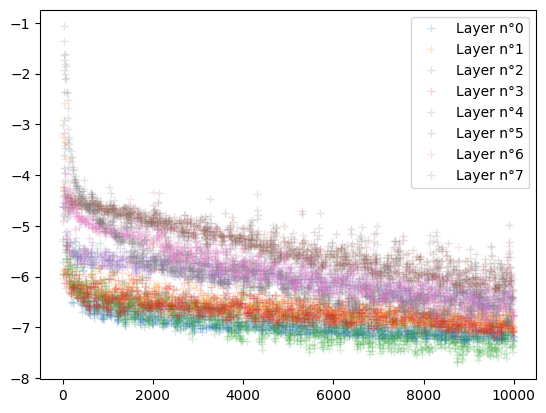

In [11]:
losses = [[] for _ in range(loaded_N)]
idxs = [[] for _ in range(loaded_N)]
for i, (k, loss) in enumerate(hist):
    losses[k] += [np.log(loss)]
    idxs[k] += [i]
    
for i in range(loaded_N):
    plt.plot(idxs[i], losses[i], "+", alpha=0.2, label=f"Layer n°{i}")

plt.legend()

Text(0.5, 1.0, 'new model')

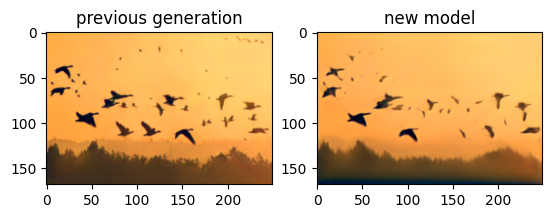

In [33]:
def generate_one(N):# scale la plus petite
    img = torch.zeros_like(scales[loaded_N-1]).to(device)   
    z   = torch.randn_like(img) * loaded_sigma_n[loaded_N-1]
    scale = torch.tensor([(loaded_N-1)/(loaded_N)]).to(device)
    img = model(z, scale)                       

    # on remonte le réseau
    for s in range(loaded_N-2, N-1, -1):               
        img_up = F.interpolate(img,
                                size=scales[s].shape[2:],
                                mode='bilinear', align_corners=False)
        z      = torch.randn_like(img_up) * loaded_sigma_n[s]
        scale = torch.tensor([s/(loaded_N)]).to(device)
        img    = model(z + img_up, scale) + img_up

    return img


generation_prev = generate_multiscale(imgs_ref=scales, Generators=loaded_generators,sigma_n=loaded_sigma_n,N=loaded_N,device=device,start_scale=loaded_N-1)[0].cpu().squeeze()
generation_new = generate_one(0).cpu()

fig, (a1, a2) = plt.subplots(1, 2)
a1.imshow(pil_from_minus1to1(generation_prev))
a1.set_title("previous generation")

a2.imshow(pil_from_minus1to1(generation_new))
a2.set_title("new model")

In [36]:
n_iter = 10000
batch = 10
n_hidden = 64
lr = 5e-4 
betas = (0.5, 0.999) 
model = GeneratorOne(n_hidden).to(device)
opt = optim.Adam(model.parameters(), lr=lr, betas=betas)

hist = []
for i in tqdm(range(n_iter)):
    opt.zero_grad()
    k = np.random.randint(loaded_N)

    with torch.no_grad():
        x = regenerate_prev_full_batch(k, loaded_N, loaded_generators, loaded_sigma_n, batch=batch).to(device)
        z = torch.randn_like(x) * loaded_sigma_n[k]
        x += z
        target = loaded_generators[k](x)

    scale = torch.tensor([k/(loaded_N) for _ in range(batch)]).to(device)
    output = model(x, scale)
    
    loss = F.mse_loss(output, target)
    loss.backward()
    opt.step()
    hist += [(k, float(loss.detach().cpu()))]


 63%|██████▎   | 6289/10000 [01:59<01:10, 52.71it/s]


KeyboardInterrupt: 